### 👨‍🏭 Albertus Septian Angkuw

### Pembuatan Call Graph

In [1]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
currentPath = input()
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi


In [3]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [4]:
folderSC = "asciinema"
os.system(f'py_files=$(find {currentPath}/{folderSC} -type f -name "*.py") && pycg --package {folderSC} $py_files > {folderSC}.json ')

scannedFiles = walkTroughFolder(folderSC)
print(f'Total Files Scanned py Source Code: {len(scannedFiles)}')

Total Files Scanned py Source Code: 31


### Pembacaan Hasil Call Graph JSON

In [5]:
import json
cgFile = open(f'{currentPath}/{folderSC}.json')
cgSource = json.load(cgFile)

In [6]:
list(cgSource.values())[:3]

[['setuptools.setup', '<builtin>.open', 'sys.exit'], [], []]

### Visualisasi Call Graph

In [7]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [9]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename=folderSC):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

#### Call Graph Raw

In [10]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [11]:
buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/asciinema-RAW-CG.svg


#### Filter Call diluar Project

In [12]:
callGraphFiltered = {}
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource != folderSC:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource != folderSC:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 60 
Total Edge: 101 <['asciinema', 'asciinema.recorder', 'asciinema.term.get_size']>
Total OutsideEdge: 34 <['pty', 'shutil', 'multiprocessing']>


In [13]:
buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/asciinema-CG.svg


#### Pemberian Weight pada Graph

In [14]:
weightedGraph = {}
weightedGraph[folderSC] = {}
for file in scannedFiles:
    newKey = '.'.join(file[:-3].split("/")[2:])
    weightedGraph[newKey] = {}


In [15]:
weightedGraph

{'asciinema': {},
 'setup': {},
 'tests.config_test': {},
 'tests.asciicast.v2_test': {},
 'tests.asciicast.__init__': {},
 'tests.test_helper': {},
 'tests.pty_test': {},
 'tests.__init__': {},
 'asciinema.term': {},
 'asciinema.asciicast.v2': {},
 'asciinema.asciicast.v1': {},
 'asciinema.asciicast.__init__': {},
 'asciinema.asciicast.events': {},
 'asciinema.asciicast.raw': {},
 'asciinema.__main__': {},
 'asciinema.pty': {},
 'asciinema.recorder': {},
 'asciinema.urllib_http_adapter': {},
 'asciinema.http_adapter': {},
 'asciinema.async_worker': {},
 'asciinema.__init__': {},
 'asciinema.config': {},
 'asciinema.notifier': {},
 'asciinema.api': {},
 'asciinema.commands.auth': {},
 'asciinema.commands.upload': {},
 'asciinema.commands.play': {},
 'asciinema.commands.cat': {},
 'asciinema.commands.command': {},
 'asciinema.commands.__init__': {},
 'asciinema.commands.record': {},
 'asciinema.player': {}}

In [16]:
for x in callGraphFiltered:
    if x  in weightedGraph:
        print(x)

asciinema.__main__


In [17]:
callGraphFiltered['asciinema.recorder.record']

{'asciinema.recorder.async_notifier.__init__': 1,
 'asciinema.asciicast.v2.get_duration': 1,
 'asciinema.term.get_size': 1,
 'asciinema.recorder.async_writer.__init__': 1}

In [18]:
currIter = 0
for call, listConn in callGraphFiltered.items():
    if call in weightedGraph:
        print(call , listConn)
        #???
    parentCall = call
    while (parentCall not in weightedGraph):
        parentCall = parentCall.rsplit('.', 1)[0]
    
    for conn, weight in listConn.items():
        parentConn = conn.rsplit('.', 1)[0]
        while (parentConn not in weightedGraph):
            parentConn = parentConn.rsplit('.', 1)[0]
             
        if parentConn not in weightedGraph[parentCall]:
            weightedGraph[parentCall][parentConn] = 1
        else:
            weightedGraph[parentCall][parentConn] += 1
    currIter+=1   


asciinema.__main__ {'asciinema.__main__.main': 1}


In [19]:
buatGraphviz(weightedGraph ,filename=f'{folderSC}-W-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/asciinema-W-CG.svg


#### Representasi Call Graph menjadi Adjacency Matrix

In [20]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    for _, connection in graphSource.items():
        for name, weight in connection.items():
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    return adjMatrix, listLabel

In [22]:
adjMatrix, listLabel = createAdjacentMatrix(weightedGraph)
print(listLabel)

{'asciinema': 0, 'setup': 1, 'tests.config_test': 2, 'tests.asciicast.v2_test': 3, 'tests.asciicast.__init__': 4, 'tests.test_helper': 5, 'tests.pty_test': 6, 'tests.__init__': 7, 'asciinema.term': 8, 'asciinema.asciicast.v2': 9, 'asciinema.asciicast.v1': 10, 'asciinema.asciicast.__init__': 11, 'asciinema.asciicast.events': 12, 'asciinema.asciicast.raw': 13, 'asciinema.__main__': 14, 'asciinema.pty': 15, 'asciinema.recorder': 16, 'asciinema.urllib_http_adapter': 17, 'asciinema.http_adapter': 18, 'asciinema.async_worker': 19, 'asciinema.__init__': 20, 'asciinema.config': 21, 'asciinema.notifier': 22, 'asciinema.api': 23, 'asciinema.commands.auth': 24, 'asciinema.commands.upload': 25, 'asciinema.commands.play': 26, 'asciinema.commands.cat': 27, 'asciinema.commands.command': 28, 'asciinema.commands.__init__': 29, 'asciinema.commands.record': 30, 'asciinema.player': 31}


In [23]:
np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

#### Clustering

In [24]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster,linkage
from scipy.spatial.distance import pdist

In [26]:
#Normalisasi Data
#sklearn.preprocessing.normalize()

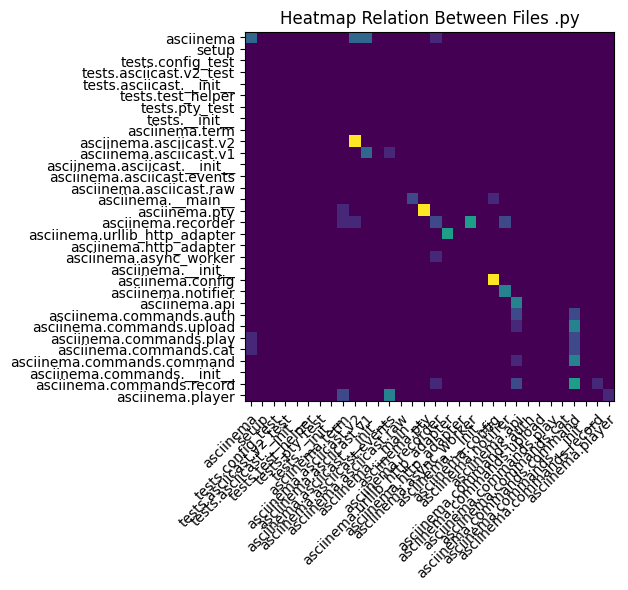

In [27]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(adjMatrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Relation Between Files .py")

# plt.figure(figsize=(20,6))
plt.show()

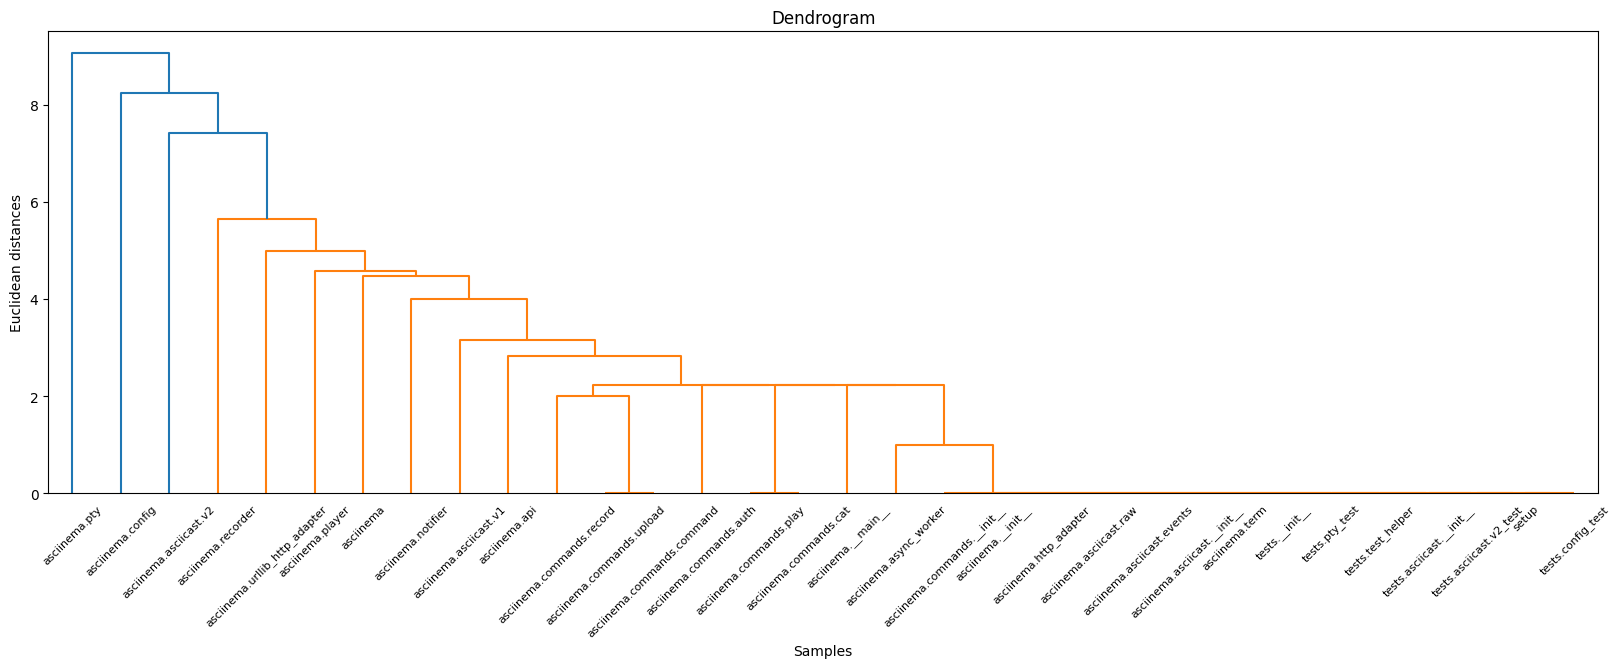

In [28]:
plt.figure(figsize=(20,6))
z = linkage(adjMatrix)
dend = sch.dendrogram(z,labels=list(listLabel))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

##### Todo: Pemilihan Cluster Terbaik berdasarkan ....